In [2]:
import tensorflow_core as tf
import numpy as np
from BregmanToolkit.bregman import suite as st
import matplotlib.pyplot as plt

/home/howard/collaborative-recommender/notebook


In [4]:
filenames = tf.train.match_filenames_once(
    "/home/howard/collaborative-recommender/data/TalkingMachinesPodcast.wav"
)
count_num_files = tf.size(filenames)
filename_queue = tf.train.string_input_producer(filenames)
reader = tf.WholeFileReader()
filename, file_contents = reader.read(filename_queue)

In [5]:
sess = tf.Session()
init = (tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init)

(None, None)

In [6]:
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord, sess=sess)

In [8]:
def get_chromagram(sess):
    F = st.Chromagram(
        sess.run(filename).decode("utf-8"), nfft=16384, wfft=8192, nhop=2205
    )
    return F.X

In [9]:
def extract_feature_vector(sess, chroma_data):
    chroma = tf.placeholder(tf.float32)
    max_freqs = tf.argmax(chroma, 0)  # first division

    num_features, num_samples = np.shape(chroma_data)
    freq_vals = sess.run(max_freqs, feed_dict={chroma: chroma_data})
    hist, _ = np.histogram(freq_vals, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    return hist.astype(float) / num_samples

In [10]:
k = 2
max_iterations = 100
part_size = 20

In [11]:
def get_dataset(sess):
    num_files = sess.run(count_num_files)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    xs = []
    for _ in range(num_files):
        chroma_data = get_chromagram(sess)

        for i in range(int(chroma_data.shape[1] / part_size)):
            chroma_part = chroma_data[:, i * part_size : (i + 1) * part_size]
            x = np.matrix(extract_feature_vector(sess, chroma_part))

            if len(xs) == 0:
                xs = x
            else:
                xs = np.vstack((xs, x))

    coord.request_stop()
    coord.join()

    return xs

In [12]:
def initial_centroids(X, k):
    # assign centroids label
    # 1st centroids -> cluster 0
    # 2nd centroids -> cluster 1
    return X[0:k, :]

In [13]:
def assign_cluster(X, centroids):
    expanded_vectors = tf.expand_dims(X, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)

    # calculate distance from each vector to each centroids
    distances = tf.reduce_sum(
        tf.square(tf.subtract(expanded_vectors, expanded_centroids)), 2
    )

    return tf.argmin(distances, 0)

In [14]:
def recenter_centroids(X, Y, k):
    sums = tf.unsorted_segment_sum(X, Y, k)
    counts = tf.unsorted_segment_sum(tf.ones_like(X), Y, k)

    return sums / counts

In [15]:
X = get_dataset(sess)

centroids = initial_centroids(X, k)

i, coveraged = 0, False
while not coveraged and i < max_iterations:
    i += 1
    Y = sess.run(assign_cluster(X, centroids))
    centroids = sess.run(recenter_centroids(X, Y, k))
print(centroids)

[[0.04230769 0.04615385 0.09230769 0.13076923 0.21923077 0.23846154
  0.07307692 0.03846154 0.01153846 0.03461538 0.06923077 0.00384615]
 [0.03333333 0.05833333 0.03611111 0.05555556 0.06111111 0.11666667
  0.23611111 0.10833333 0.04444444 0.075      0.11388889 0.06111111]]


In [69]:
segments = sess.run(assign_cluster(X, centroids))
print(f"Number of segment = {len(segments)}")
for i in range(len(segments)):
    seconds = (i * part_size) / float(10) # chromagram width = 10 * t(sound length)
    min, sec = divmod(seconds, 60)
    print(f"{min}m, {sec}s: {segments[i]}")

Number of segment = 31
(31, 12)
0.0m, 0.0s: 0
0.0m, 2.0s: 1
0.0m, 4.0s: 0
0.0m, 6.0s: 1
0.0m, 8.0s: 1
0.0m, 10.0s: 0
0.0m, 12.0s: 1
0.0m, 14.0s: 1
0.0m, 16.0s: 0
0.0m, 18.0s: 0
0.0m, 20.0s: 1
0.0m, 22.0s: 1
0.0m, 24.0s: 1
0.0m, 26.0s: 0
0.0m, 28.0s: 1
0.0m, 30.0s: 1
0.0m, 32.0s: 1
0.0m, 34.0s: 1
0.0m, 36.0s: 0
0.0m, 38.0s: 1
0.0m, 40.0s: 0
0.0m, 42.0s: 1
0.0m, 44.0s: 1
0.0m, 46.0s: 1
0.0m, 48.0s: 0
0.0m, 50.0s: 0
0.0m, 52.0s: 1
0.0m, 54.0s: 0
0.0m, 56.0s: 0
0.0m, 58.0s: 0
1.0m, 0.0s: 1


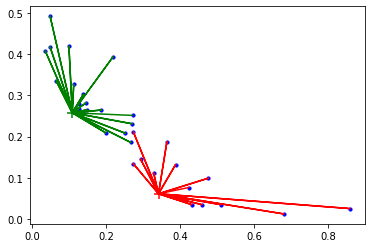

In [97]:
start_pitch = 0
median_pitch = 6
end_pitch = 12

pow_grain = 1.45

dim2_X = np.hstack(
    (
        np.sum(np.power(X[:, start_pitch : median_pitch], pow_grain), 1),
        np.sum(np.power(X[:, median_pitch : end_pitch], pow_grain), 1),
    )
)
dim2_centroids = np.hstack(
    (
        np.sum(np.power(centroids[:, start_pitch : median_pitch], pow_grain), 1).reshape((2, 1)),
        np.sum(np.power(centroids[:, median_pitch : end_pitch], pow_grain), 1).reshape((2, 1)),
    )
)

plt.scatter(
    np.array(dim2_X[:, 0:1].copy().flat),
    np.array(dim2_X[:, 1:2].copy().flat),
    c='b', marker='o', s=10
)
 
# cluster 1 centroid
plt.scatter(
    np.array(dim2_centroids[0:1, 0:1].copy().flat),
    np.array(dim2_centroids[0:1, 1:2].copy().flat),
    c='r', marker='+', s=90
)
# cluster 2 centroid
plt.scatter(
    np.array(dim2_centroids[1:2, 0:1].copy().flat),
    np.array(dim2_centroids[1:2, 1:2].copy().flat),
    c='g', marker='+', s=90
)

segments = sess.run(assign_cluster(X, centroids))
cluster_1_x, cluster_1_y = np.array([]), np.array([])
cluster_2_x, cluster_2_y = np.array([]), np.array([])

for i in range(len(segments)):
    plot_x = None
    if segments[i] == 0:
        plot_x = np.hstack((
            np.sum(np.power(X[i, start_pitch:median_pitch], pow_grain), 1),
            np.sum(np.power(centroids[segments[i], start_pitch:median_pitch], pow_grain), 0).reshape((1, 1))))
        plot_y = np.hstack((
            np.sum(np.power(X[i, median_pitch:end_pitch], pow_grain), 1),
            np.sum(np.power(centroids[segments[i], median_pitch:end_pitch], pow_grain), 0).reshape((1, 1))))

        cluster_1_x = np.append(cluster_1_x, np.array(plot_x.copy().flat))
        cluster_1_y = np.append(cluster_1_y, np.array(plot_y.copy().flat))
    else:
        plot_x = np.hstack((
            np.sum(np.power(X[i, start_pitch:median_pitch], pow_grain), 1),
            np.sum(np.power(centroids[segments[i], start_pitch:median_pitch], pow_grain), 0).reshape((1, 1))))
        plot_y = np.hstack((
            np.sum(np.power(X[i, median_pitch:end_pitch], pow_grain), 1),
            np.sum(np.power(centroids[segments[i], median_pitch:end_pitch], pow_grain), 0).reshape((1, 1))))
        
        cluster_2_x = np.append(cluster_2_x, np.array(plot_x.copy().flat))
        cluster_2_y = np.append(cluster_2_y, np.array(plot_y.copy().flat))

plt.plot(cluster_1_x, cluster_1_y, 'r')
plt.plot(cluster_2_x, cluster_2_y, 'g')
plt.show()